## Import packages

In [1]:
import sys
print(sys.version)

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
from torch import nn
from torch.utils.data import TensorDataset
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from torchvision.transforms import v2
from rasterio.plot import show

import os
import pandas as pd
import imageio.v2 as imageio

from PIL import Image
import rasterio

3.11.8 | packaged by conda-forge | (main, Feb 16 2024, 20:40:50) [MSC v.1937 64 bit (AMD64)]


## Import the tabular data

In [2]:
# Specify the path to your CSV file
csv_file_path = '../buffalo_local_data_id/buffalo_2005_data_df_lag_1hr_n10297.csv'

# Read the CSV file into a DataFrame
buffalo_df = pd.read_csv(csv_file_path)

# Display the first few rows of the DataFrame
print(buffalo_df.head())

             x_            y_                    t_    id           x1_  \
0  41969.310875 -1.435671e+06  2018-07-25T01:04:23Z  2005  41969.310875   
1  41921.521939 -1.435654e+06  2018-07-25T02:04:39Z  2005  41921.521939   
2  41779.439594 -1.435601e+06  2018-07-25T03:04:17Z  2005  41779.439594   
3  41841.203272 -1.435635e+06  2018-07-25T04:04:39Z  2005  41841.203272   
4  41655.463332 -1.435604e+06  2018-07-25T05:04:27Z  2005  41655.463332   

            y1_           x2_           y2_     x2_cent    y2_cent  ...  \
0 -1.435671e+06  41921.521939 -1.435654e+06  -47.788936  16.857110  ...   
1 -1.435654e+06  41779.439594 -1.435601e+06 -142.082345  53.568427  ...   
2 -1.435601e+06  41841.203272 -1.435635e+06   61.763677 -34.322938  ...   
3 -1.435635e+06  41655.463332 -1.435604e+06 -185.739939  31.003534  ...   
4 -1.435604e+06  41618.651923 -1.435608e+06  -36.811409  -4.438037  ...   

    bearing  bearing_sin  bearing_cos        ta    cos_ta         x_min  \
0  2.802478     0.33265

## Importing spatial data

## Global layers

### NDVI

In [3]:
file_path = '../mapping/cropped rasters/ndvi_2018-19_late_dry.tif'
# read the raster file
with rasterio.open(file_path) as src:
    # Read the raster band as separate variable
    ndvi_global = src.read(1)
    # Get the metadata of the raster
    ndvi_meta = src.meta
    raster_transform = src.transform


{'driver': 'GTiff', 'dtype': 'float32', 'nodata': nan, 'width': 2400, 'height': 2280, 'count': 1, 'crs': CRS.from_epsg(3112), 'transform': Affine(25.0, 0.0, 0.0,
       0.0, -25.0, -1406000.0)}
| 25.00, 0.00, 0.00|
| 0.00,-25.00,-1406000.00|
| 0.00, 0.00, 1.00|
(2280, 2400)


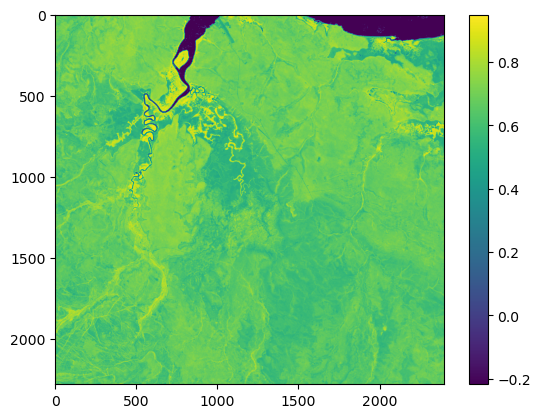

In [4]:
print(ndvi_meta)
print(raster_transform)
print(ndvi_global.shape)

# Replace NaNs in the original array with -1, which represents water
ndvi_global = np.nan_to_num(ndvi_global, nan=-1.0)

# from the the global layer (calculated in R)
ndvi_max = 0.8812606
ndvi_min = -0.6637671

ndvi_global_tens = torch.from_numpy(ndvi_global)

# Normalizing the data
ndvi_global_norm = (ndvi_global_tens - ndvi_min) / (ndvi_max - ndvi_min)

plt.imshow(ndvi_global_norm.numpy())
plt.colorbar()  
plt.show()


### Canopy cover

In [5]:
file_path = '../mapping/cropped rasters/canopy_cover.tif'
# read the raster file
with rasterio.open(file_path) as src:
    # Read the raster band as separate variable
    canopy_global = src.read(1)
    # Get the metadata of the raster
    canopy_meta = src.meta


{'driver': 'GTiff', 'dtype': 'float32', 'nodata': -3.3999999521443642e+38, 'width': 2400, 'height': 2280, 'count': 1, 'crs': CRS.from_epsg(3112), 'transform': Affine(25.0, 0.0, 0.0,
       0.0, -25.0, -1406000.0)}
(2280, 2400)


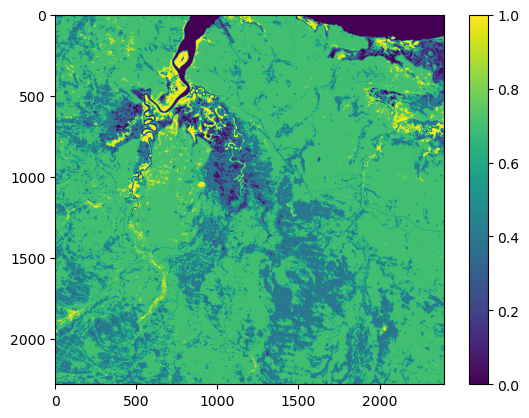

In [6]:
print(canopy_meta)
print(canopy_global.shape)

# from the stack of local layers
canopy_max = 82.5000
canopy_min = 0.0

canopy_global_tens = torch.from_numpy(canopy_global)

# Normalizing the data
canopy_global_norm = (canopy_global_tens - canopy_min) / (canopy_max - canopy_min)

plt.imshow(canopy_global_norm.numpy())
plt.colorbar()  
plt.show()


### Herbaceous vegetation

In [7]:
file_path = '../mapping/cropped rasters/veg_herby.tif'
# read the raster file
with rasterio.open(file_path) as src:
    # Read the raster band as separate variable
    herby_global = src.read(1)
    # Get the metadata of the raster
    herby_meta = src.meta


{'driver': 'GTiff', 'dtype': 'float32', 'nodata': -3.3999999521443642e+38, 'width': 2400, 'height': 2280, 'count': 1, 'crs': CRS.from_epsg(3112), 'transform': Affine(25.0, 0.0, 0.0,
       0.0, -25.0, -1406000.0)}
(2280, 2400)


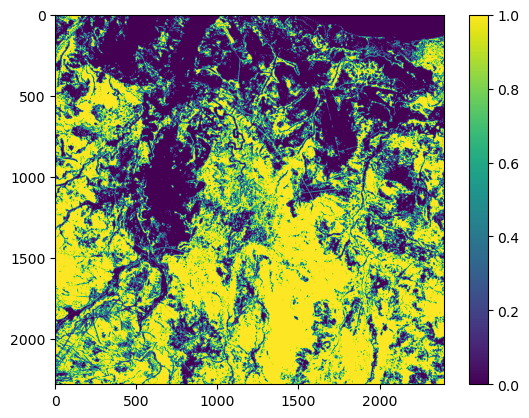

In [8]:
print(herby_meta)
print(herby_global.shape)

# from the stack of local layers
herby_max = 1.0
herby_min = 0.0

herby_global_tens = torch.from_numpy(herby_global)

# Normalizing the data
herby_global_norm = (herby_global_tens - herby_min) / (herby_max - herby_min)

plt.imshow(herby_global_norm.numpy())
plt.colorbar()  
plt.show()


### Slope

In [9]:
file_path = '../mapping/cropped rasters/slope.tif'
# read the raster file
with rasterio.open(file_path) as src:
    # Read the raster band as separate variable
    slope_global = src.read(1)
    # Get the metadata of the raster
    slope_meta = src.meta
    slope_transform = src.transform # same as the raster transform in the NDVI raster read

print(slope_global)
print(slope_transform)


[[       nan        nan        nan ...        nan        nan        nan]
 [       nan 0.3352837  0.39781624 ... 0.         0.                nan]
 [       nan 0.3983888  0.48142004 ... 0.         0.                nan]
 ...
 [       nan 2.215875   1.9798415  ... 1.5078747  1.268342          nan]
 [       nan 1.9740707  1.7354656  ... 1.697194   1.4880029         nan]
 [       nan        nan        nan ...        nan        nan        nan]]
| 25.00, 0.00, 0.00|
| 0.00,-25.00,-1406000.00|
| 0.00, 0.00, 1.00|


{'driver': 'GTiff', 'dtype': 'float32', 'nodata': nan, 'width': 2400, 'height': 2280, 'count': 1, 'crs': CRS.from_epsg(3112), 'transform': Affine(25.0, 0.0, 0.0,
       0.0, -25.0, -1406000.0)}
(2280, 2400)


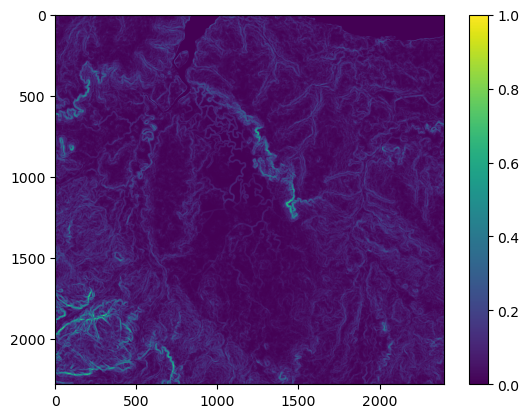

In [10]:
print(slope_meta)
print(slope_global.shape)

# Replace NaNs in the original array with 0
slope_global = np.nan_to_num(slope_global, nan=0.0)

# from the stack of local layers
slope_max = 15.83363
slope_min = 0.0006

slope_global_tens = torch.from_numpy(slope_global)

# Normalizing the data
slope_global_norm = (slope_global_tens - slope_min) / (slope_max - slope_min)

plt.imshow(slope_global_norm.numpy())
plt.colorbar()  
plt.show()


Testing functions for selecting subsets of the raster layer, using torch objects

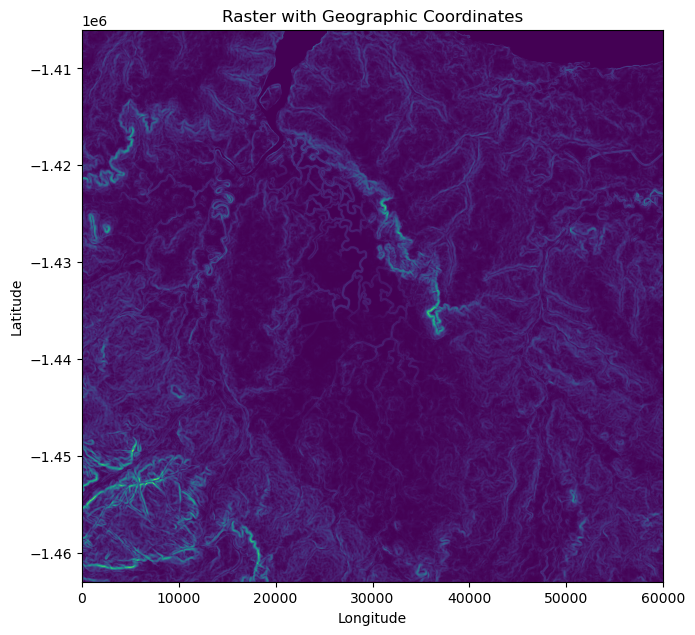

In [11]:
# Create a figure and axis with matplotlib
fig, ax = plt.subplots(figsize=(7.5, 7.5))

# Plot the raster
show(slope_global, transform=raster_transform, ax=ax, cmap='viridis')

# Set the title and labels
ax.set_title('Raster with Geographic Coordinates')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# Show the plot
plt.show()

In [12]:
x, y = 5.9e4, -1.447e6
print(x, y)

# Convert geographic coordinates to pixel coordinates
px, py = ~raster_transform * (x, y)
# Round pixel coordinates to integers
px, py = int(round(px)), int(round(py))

# Print the pixel coordinates	
print(px, py)

59000.0 -1447000.0
2360 1640


In [13]:
window_size = 101

# Define half the window size
half_window = window_size // 2

# Calculate the window boundaries
row_start = py - half_window
row_stop = py + half_window + 1
col_start = px - half_window
col_stop = px + half_window + 1

# Initialize the subset array with zeros (or any other padding value)
subset = np.zeros((window_size, window_size), dtype=slope_global.dtype)

# Calculate the valid region within the raster bounds
valid_row_start = max(0, row_start)
valid_row_stop = min(slope_global.shape[0], row_stop)
valid_col_start = max(0, col_start)
valid_col_stop = min(slope_global.shape[1], col_stop)

# Calculate the corresponding region in the subset array
subset_row_start = valid_row_start - row_start
subset_row_stop = subset_row_start + (valid_row_stop - valid_row_start)
subset_col_start = valid_col_start - col_start
subset_col_stop = subset_col_start + (valid_col_stop - valid_col_start)

# Copy the valid region from the raster array to the subset array
subset[subset_row_start:subset_row_stop, subset_col_start:subset_col_stop] = \
    slope_global[valid_row_start:valid_row_stop, valid_col_start:valid_col_stop]

Plot the raster layer

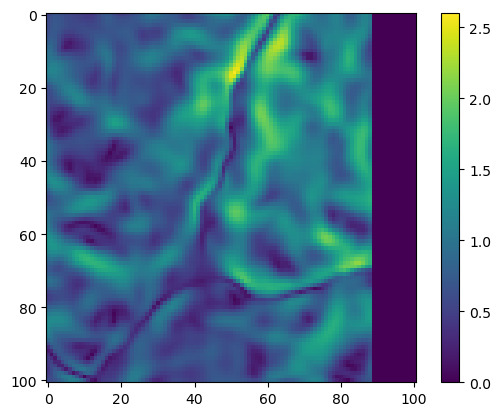

In [14]:
# plot the subset
plt.imshow(subset, cmap='viridis')
plt.colorbar()
plt.show()

## Subset function

In [15]:
def subset_raster_with_padding_torch(raster_tensor, x, y, window_size, transform):
    # Convert geographic coordinates to pixel coordinates
    px, py = ~transform * (x, y)
    
    # Round pixel coordinates to integers
    px, py = int(round(px)), int(round(py))
    
    # Define half the window size
    half_window = window_size // 2
    
    # Calculate the window boundaries
    row_start = py - half_window
    row_stop = py + half_window + 1
    col_start = px - half_window
    col_stop = px + half_window + 1
    
    # Initialize the subset tensor with zeros (or any other padding value)
    # subset = torch.zeros((window_size, window_size), dtype=raster_tensor.dtype)
    # Create a layer with -inf values - doesn't work with CNNs, use -1 instead  
    # subset = torch.full((window_size, window_size), torch.tensor(-float('inf')), dtype=raster_tensor.dtype)
    subset = torch.full((window_size, window_size), -1.0, dtype=raster_tensor.dtype)
    
    # Calculate the valid region within the raster bounds
    valid_row_start = max(0, row_start)
    valid_row_stop = min(raster_tensor.shape[0], row_stop)
    valid_col_start = max(0, col_start)
    valid_col_stop = min(raster_tensor.shape[1], col_stop)
    
    # Calculate the corresponding region in the subset tensor
    subset_row_start = valid_row_start - row_start
    subset_row_stop = subset_row_start + (valid_row_stop - valid_row_start)
    subset_col_start = valid_col_start - col_start
    subset_col_stop = subset_col_start + (valid_col_stop - valid_col_start)
    
    # Copy the valid region from the raster tensor to the subset tensor
    subset[subset_row_start:subset_row_stop, subset_col_start:subset_col_stop] = \
        raster_tensor[valid_row_start:valid_row_stop, valid_col_start:valid_col_stop]
    
    return subset, col_start, row_start

Testing the subset function

Text(0.5, 1.0, 'Slope Subset')

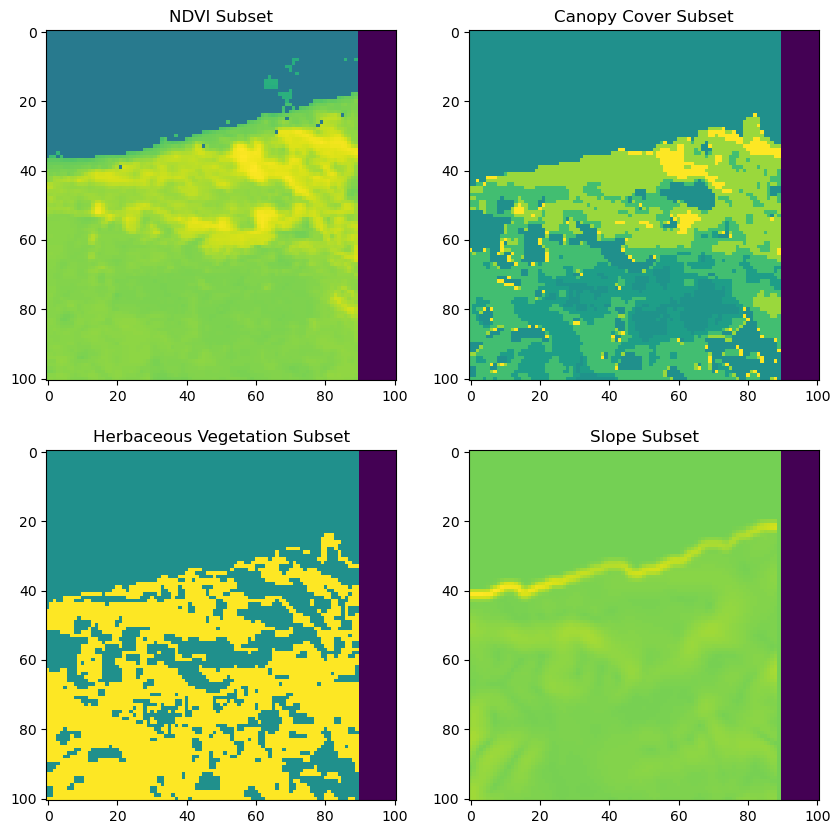

In [16]:
x = 5.9e4
y = -1.41e6
window_size = 101

ndvi_subset, origin_x, origin_y = subset_raster_with_padding_torch(ndvi_global_norm, x, y, window_size, raster_transform)
canopy_subset, origin_x, origin_y = subset_raster_with_padding_torch(canopy_global_norm, x, y, window_size, raster_transform)
herby_subset, origin_x, origin_y = subset_raster_with_padding_torch(herby_global_norm, x, y, window_size, raster_transform)
slope_subset, origin_x, origin_y = subset_raster_with_padding_torch(slope_global_norm, x, y, window_size, raster_transform)

# Plot the subset
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

axs[0, 0].imshow(ndvi_subset.numpy(), cmap='viridis')
axs[0, 0].set_title('NDVI Subset')
# axs[0, 0].axis('off')

axs[0, 1].imshow(canopy_subset.numpy(), cmap='viridis')
axs[0, 1].set_title('Canopy Cover Subset')
# axs[0, 1].axis('off')

axs[1, 0].imshow(herby_subset.numpy(), cmap='viridis')
axs[1, 0].set_title('Herbaceous Vegetation Subset')
# axs[1, 0].axis('off')

axs[1, 1].imshow(slope_subset.numpy(), cmap='viridis')
axs[1, 1].set_title('Slope Subset')
# axs[1, 1].axis('off')



In [17]:
x = 3.7e4
y = -1.435e6
print(x, y)

# Convert geographic coordinates to pixel coordinates
px, py = ~raster_transform * (x, y)
# Round pixel coordinates to integers
px, py = int(round(px)), int(round(py))

# Print the pixel coordinates	
print(px, py)

37000.0 -1435000.0
1480 1160


# Running the model on the subset layers

### Set the device for the model

In [18]:
# train on the GPU or on the CPU, if a GPU is not available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f"Using {device} device")

Using cpu device


# Define the model

In [19]:
class Conv2d_block_toFC(nn.Module):
    def __init__(self, params):
        super(Conv2d_block_toFC, self).__init__()
        self.batch_size = params.batch_size
        self.input_channels = params.input_channels
        self.output_channels = params.output_channels
        self.kernel_size = params.kernel_size
        self.stride = params.stride
        self.kernel_size_mp = params.kernel_size_mp
        self.stride_mp = params.stride_mp
        self.padding = params.padding
        self.image_dim = params.image_dim
        self.device = params.device

        self.conv2d = nn.Sequential(
        nn.Conv2d(in_channels=self.input_channels, out_channels=self.output_channels, kernel_size=self.kernel_size, stride=self.stride, padding=self.padding),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=self.kernel_size_mp, stride=self.stride_mp),
        nn.Conv2d(in_channels=self.output_channels, out_channels=self.output_channels, kernel_size=self.kernel_size, stride=self.stride, padding=self.padding),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=self.kernel_size_mp, stride=self.stride_mp),
        nn.Flatten())

    def forward(self, x):
        return self.conv2d(x)
    

class Conv2d_block_spatial(nn.Module):
    def __init__(self, params):
        super(Conv2d_block_spatial, self).__init__()
        self.batch_size = params.batch_size
        self.input_channels = params.input_channels
        self.output_channels = params.output_channels
        self.kernel_size = params.kernel_size
        self.stride = params.stride
        # self.kernel_size_mp = params.kernel_size_mp
        # self.stride_mp = params.stride_mp
        self.padding = params.padding
        self.image_dim = params.image_dim
        self.device = params.device

        self.conv2d = nn.Sequential(
        nn.Conv2d(in_channels=self.input_channels, out_channels=self.output_channels, kernel_size=self.kernel_size, stride=self.stride, padding=self.padding),
        nn.ReLU(),
        nn.Conv2d(in_channels=self.output_channels, out_channels=self.output_channels, kernel_size=self.kernel_size, stride=self.stride, padding=self.padding),
        nn.ReLU(),
        nn.Conv2d(in_channels=self.output_channels, out_channels=1, kernel_size=self.kernel_size, stride=self.stride, padding=self.padding)
        )

    def forward(self, x):
        # print("Shape before squeeze:", self.conv2d(x).shape)
        conv2d_spatial = self.conv2d(x).squeeze(dim = 1)
        # print("Shape before logsumexp:", conv2d_spatial.shape)
        conv2d_spatial = conv2d_spatial - torch.logsumexp(conv2d_spatial, dim = (1, 2), keepdim = True)
        # conv2d_spatial = conv2d_spatial/torch.sum(conv2d_spatial)
        return conv2d_spatial


class FCN_block_all_habitat(nn.Module):
    def __init__(self, params):
        super(FCN_block_all_habitat, self).__init__()
        self.batch_size = params.batch_size
        self.dense_dim_in_all = params.dense_dim_in_all
        self.dense_dim_hidden = params.dense_dim_hidden
        self.dense_dim_out = params.dense_dim_out
        self.image_dim = params.image_dim
        self.device = params.device
        self.dropout = params.dropout

        self.ffn = nn.Sequential(
            nn.Linear(self.dense_dim_in_all, self.dense_dim_hidden),
            nn.Dropout(self.dropout),
            nn.ReLU(),
            nn.Linear(self.dense_dim_hidden, self.dense_dim_hidden),
            nn.Dropout(self.dropout),
            nn.ReLU(),
            nn.Linear(self.dense_dim_hidden, self.image_dim * self.image_dim)
        )
    
    def forward(self, x):
        return self.ffn(x)


class FCN_block_all_movement(nn.Module):
    def __init__(self, params):
        super(FCN_block_all_movement, self).__init__()
        self.batch_size = params.batch_size
        self.dense_dim_in_all = params.dense_dim_in_all
        self.dense_dim_hidden = params.dense_dim_hidden
        self.dense_dim_out = params.dense_dim_out
        self.image_dim = params.image_dim
        self.device = params.device
        self.num_movement_params = params.num_movement_params
        self.dropout = params.dropout

        self.ffn = nn.Sequential(
            nn.Linear(self.dense_dim_in_all, self.dense_dim_hidden),
            nn.Dropout(self.dropout),
            nn.ReLU(),
            nn.Linear(self.dense_dim_hidden, self.dense_dim_hidden),
            nn.Dropout(self.dropout),
            nn.ReLU(),
            nn.Linear(self.dense_dim_hidden, self.num_movement_params)
        )
    
    def forward(self, x):
        return self.ffn(x)
    
class FCN_block_nonspatial(nn.Module):
    def __init__(self, params):
        super(FCN_block_nonspatial, self).__init__()
        self.batch_size = params.batch_size
        self.dense_dim_in_nonspatial = params.dense_dim_in_nonspatial
        self.dense_dim_hidden = params.dense_dim_hidden
        self.dense_dim_out = params.dense_dim_out
        self.image_dim = params.image_dim
        self.device = params.device
        self.dropout = params.dropout

        self.ffn = nn.Sequential(
            nn.Linear(self.dense_dim_in_nonspatial, self.dense_dim_hidden),
            nn.Dropout(self.dropout),
            nn.ReLU(),
            nn.Linear(self.dense_dim_hidden, self.dense_dim_hidden),
            nn.Dropout(self.dropout),
            nn.ReLU(),
            nn.Linear(self.dense_dim_hidden, self.dense_dim_out)
        )
    
    def forward(self, x):
        return self.ffn(x)


class Params_to_Grid_Block(nn.Module):
    def __init__(self, params):
        super(Params_to_Grid_Block, self).__init__()
        self.batch_size = params.batch_size
        self.image_dim = params.image_dim
        self.pixel_size = params.pixel_size
        self.center = self.image_dim // 2
        y, x = np.indices((self.image_dim, self.image_dim))
        self.distance_layer = torch.from_numpy(np.sqrt((self.pixel_size*(x - self.center))**2 + (self.pixel_size*(y - self.center))**2))
        # change the centre cell to the average distance from the centre to the edge of the pixel
        self.distance_layer[self.center, self.center] = 0.56*self.pixel_size # average distance from the centre to the perimeter of the pixel (accounting for longer distances at the corners)
        self.bearing_layer = torch.from_numpy(np.arctan2(y - self.center, x - self.center))
        self.device = params.device


    # Gamma desnities for the mixture distribution
    def gamma_density(self, x, shape, scale):
        return -1*torch.lgamma(shape) -shape*torch.log(scale) + (shape - 1)*torch.log(x) - x/scale
    
    # von Mises densities for the mixture distribution
    def vonmises_density(self, x, kappa, vm_mu):
        return kappa*torch.cos(x - vm_mu) - 1*(np.log(2*torch.pi) + torch.log(torch.special.i0(kappa)))
    

    def forward(self, x, bearing):

        # parameters of the first mixture distribution
        gamma_shape1 = torch.exp(x[:, 0]).unsqueeze(0).unsqueeze(0)
        gamma_shape1 = gamma_shape1.repeat(self.image_dim, self.image_dim, 1)
        gamma_shape1 = gamma_shape1.permute(2, 0, 1)

        gamma_scale1 = torch.exp(x[:, 1]).unsqueeze(0).unsqueeze(0)
        gamma_scale1 = gamma_scale1.repeat(self.image_dim, self.image_dim, 1)
        gamma_scale1 = gamma_scale1.permute(2, 0, 1)

        gamma_weight1 = torch.exp(x[:, 2]).unsqueeze(0).unsqueeze(0)
        gamma_weight1 = gamma_weight1.repeat(self.image_dim, self.image_dim, 1)
        gamma_weight1 = gamma_weight1.permute(2, 0, 1)

        # parameters of the second mixture distribution
        gamma_shape2 = torch.exp(x[:, 3]).unsqueeze(0).unsqueeze(0)
        gamma_shape2 = gamma_shape2.repeat(self.image_dim, self.image_dim, 1)
        gamma_shape2 = gamma_shape2.permute(2, 0, 1)

        gamma_scale2 = torch.exp(x[:, 4]).unsqueeze(0).unsqueeze(0)
        gamma_scale2 = gamma_scale2.repeat(self.image_dim, self.image_dim, 1)
        gamma_scale2 = gamma_scale2.permute(2, 0, 1)

        gamma_weight2 = torch.exp(x[:, 5]).unsqueeze(0).unsqueeze(0)
        gamma_weight2 = gamma_weight2.repeat(self.image_dim, self.image_dim, 1)
        gamma_weight2 = gamma_weight2.permute(2, 0, 1)

        # Apply softmax to the weights
        gamma_weights = torch.stack([gamma_weight1, gamma_weight2], dim=0)
        gamma_weights = torch.nn.functional.softmax(gamma_weights, dim=0)
        gamma_weight1 = gamma_weights[0]
        gamma_weight2 = gamma_weights[1]

        # calculation of Gamma densities
        gamma_density_layer1 = self.gamma_density(self.distance_layer, gamma_shape1, gamma_scale1)
        gamma_density_layer2 = self.gamma_density(self.distance_layer, gamma_shape2, gamma_scale2)

        # combining both densities to create a mixture distribution using logsumexp
        logsumexp_gamma_corr = torch.max(gamma_density_layer1, gamma_density_layer2)
        gamma_density_layer = logsumexp_gamma_corr + torch.log(gamma_weight1 * torch.exp(gamma_density_layer1 - logsumexp_gamma_corr) + gamma_weight2 * torch.exp(gamma_density_layer2 - logsumexp_gamma_corr))
        # print(torch.sum(gamma_density_layer))
        # print(torch.sum(torch.exp(gamma_density_layer)))

        # normalise the gamma weights so they sum to 1
        gamma_density_layer = gamma_density_layer - torch.logsumexp(gamma_density_layer, dim = (1, 2), keepdim = True)
        # print(torch.sum(gamma_density_layer))
        # print(torch.sum(torch.exp(gamma_density_layer)))


        ## Von Mises Distributions

        # calculate the new bearing from the turning angle
        # takes in the bearing from the previous step and adds the turning angle
        # bearing_new1 = x[:, 6] + bearing[:, 0]
        bearing_new1 = 0.0 + bearing[:, 0]

        # print('Bearing.shape ', bearing.shape)
        # print('Bearing[:, 0].shape ', bearing[:, 0].shape)
        # print('Bearing[:, 0] ', bearing[:, 0])
        # the new bearing becomes the mean of the von Mises distribution
        # the estimated parameter [x:, 7] is the turning angle of the next step
        # which is always in reference to the input bearing
        vonmises_mu1 = bearing_new1.unsqueeze(0).unsqueeze(0)
        vonmises_mu1 = vonmises_mu1.repeat(self.image_dim, self.image_dim, 1)
        vonmises_mu1 = vonmises_mu1.permute(2, 0, 1)

        # parameters of the first von Mises distribution
        vonmises_kappa1 = torch.exp(x[:, 6]).unsqueeze(0).unsqueeze(0)
        vonmises_kappa1 = vonmises_kappa1.repeat(self.image_dim, self.image_dim, 1)
        vonmises_kappa1 = vonmises_kappa1.permute(2, 0, 1)

        vonmises_weight1 = torch.exp(x[:, 7]).unsqueeze(0).unsqueeze(0)
        vonmises_weight1 = vonmises_weight1.repeat(self.image_dim, self.image_dim, 1)
        vonmises_weight1 = vonmises_weight1.permute(2, 0, 1)

        # vm_mu and weight for the second von Mises distribution
        # bearing_new2 = x[:, 9] + bearing[:, 0]
        bearing_new2 = torch.pi + bearing[:, 0]

        vonmises_mu2 = bearing_new2.unsqueeze(0).unsqueeze(0)
        vonmises_mu2 = vonmises_mu2.repeat(self.image_dim, self.image_dim, 1)
        vonmises_mu2 = vonmises_mu2.permute(2, 0, 1)

        # parameters of the second von Mises distribution
        vonmises_kappa2 = torch.exp(x[:, 8]).unsqueeze(0).unsqueeze(0)
        vonmises_kappa2 = vonmises_kappa2.repeat(self.image_dim, self.image_dim, 1)
        vonmises_kappa2 = vonmises_kappa2.permute(2, 0, 1)

        vonmises_weight2 = torch.exp(x[:, 9]).unsqueeze(0).unsqueeze(0)
        vonmises_weight2 = vonmises_weight2.repeat(self.image_dim, self.image_dim, 1)
        vonmises_weight2 = vonmises_weight2.permute(2, 0, 1)

        # Apply softmax to the weights
        vonmises_weights = torch.stack([vonmises_weight1, vonmises_weight2], dim=0)
        vonmises_weights = torch.nn.functional.softmax(vonmises_weights, dim=0)
        vonmises_weight1 = vonmises_weights[0]
        vonmises_weight2 = vonmises_weights[1]

        # calculation of von Mises densities
        vonmises_density_layer1 = self.vonmises_density(self.bearing_layer, vonmises_kappa1, vonmises_mu1)
        vonmises_density_layer2 = self.vonmises_density(self.bearing_layer, vonmises_kappa2, vonmises_mu2)

        # combining both densities to create a mixture distribution using the logsumexp trick
        logsumexp_vm_corr = torch.max(vonmises_density_layer1, vonmises_density_layer2)
        vonmises_density_layer = logsumexp_vm_corr + torch.log(vonmises_weight1 * torch.exp(vonmises_density_layer1 - logsumexp_vm_corr) + vonmises_weight2 * torch.exp(vonmises_density_layer2 - logsumexp_vm_corr))
        # print(torch.sum(vonmises_density_layer))
        # print(torch.sum(torch.exp(vonmises_density_layer)))
        vonmises_density_layer = vonmises_density_layer - torch.logsumexp(vonmises_density_layer, dim = (1, 2), keepdim = True)
        # normalise so the densities sum to 1 when exponentiated
        # print(torch.sum(vonmises_density_layer))
        # print(torch.sum(torch.exp(vonmises_density_layer)))

        # combining the two distributions
        movement_grid = gamma_density_layer + vonmises_density_layer # Gamma and von Mises densities are on the log-scale
        # print('Movement grid ', torch.sum(movement_grid))
        # print(torch.sum(torch.exp(movement_grid)))
        movement_grid = movement_grid - torch.logsumexp(movement_grid, dim = (1, 2), keepdim = True)
        # print('Movement grid norm ', torch.sum(movement_grid))
        # print(torch.sum(torch.exp(movement_grid)))

        return movement_grid
    

class Scalar_to_Grid_Block(nn.Module):
    def __init__(self, params):
        super(Scalar_to_Grid_Block, self).__init__()
        self.batch_size = params.batch_size
        self.image_dim = params.image_dim
        self.device = params.device
    
    def forward(self, x):
        num_scalars = x.shape[1]
        scalar_map = x.view(x.shape[0], num_scalars, 1, 1).expand(x.shape[0], num_scalars, self.image_dim, self.image_dim)
        return scalar_map


class Vector_to_Grid_Block(nn.Module):
    def __init__(self, params):
        super(Vector_to_Grid_Block, self).__init__()
        self.batch_size = params.batch_size
        self.image_dim = params.image_dim
        self.device = params.device
    
    def forward(self, x):
        x_unnorm = x.reshape(x.shape[0], self.image_dim, self.image_dim)
        x = x_unnorm - torch.logsumexp(x_unnorm, dim = (1, 2), keepdim = True)
        return x
    
        # x = x_unnorm/torch.sum(x_unnorm)
        # return x


class ConvJointModel(nn.Module):
    def __init__(self, params):
        super(ConvJointModel, self).__init__()
        # self.conv_habitat = Conv2d_block(params)
        # self.fcn_habitat_all = FCN_block_all_habitat(params)
        # self.fcn_habitat_nonspatial = FCN_block_nonspatial(params)
        # self.habitat_grid_output = Vector_to_Grid_Block(params)

        self.scalar_grid_output = Scalar_to_Grid_Block(params)
        self.conv_habitat = Conv2d_block_spatial(params)

        self.conv_movement = Conv2d_block_toFC(params)
        self.fcn_movement_all = FCN_block_all_movement(params)
        # self.fcn_movement_nonspatial = FCN_block_nonspatial(params)
        self.movement_grid_output = Params_to_Grid_Block(params)
        self.device = params.device

    def forward(self, x):
        spatial_data_x = x[0]
        scalars_to_grid = x[1]
        # additional_data_x = x[2]
        bearing_x = x[2]

        # conv_habitat = self.conv_habitat(spatial_data_x)
        # covariates_habitat = self.fcn_habitat_nonspatial(additional_data_x)
        # all_predictors_habitat = torch.cat([conv_habitat, covariates_habitat], dim = 1)
        # # print(f"Shape after concatenation: {all_predictors_habitat.shape}")  # Debugging print
        # output_habitat = self.fcn_habitat_all(all_predictors_habitat)
        # output_habitat = self.habitat_grid_output(output_habitat)

        # SCALAR GRIDS
        scalar_grids = self.scalar_grid_output(scalars_to_grid)
        all_spatial = torch.cat([spatial_data_x, scalar_grids], dim = 1)
        # print(f"Shape after scalar grid: {all_spatial.shape}")  # Debugging print


        # HABITAT SELECTION
        output_habitat = self.conv_habitat(all_spatial)
        # print(f"Shape after CNN habitat: {output_habitat.shape}")  # Debugging print


        # MOVEMENT
        conv_movement = self.conv_movement(all_spatial)
        # print(f"Shape after CNN to FC movement: {conv_movement.shape}")  # Debugging print

        # covariates_movement = self.fcn_movement_nonspatial(additional_data_x)
        # print(f"Shape after fcn_movement_nonspatial: {covariates_movement.shape}")  # Debugging print

        # all_predictors_movement = torch.cat([conv_movement, covariates_movement], dim = 1)
        # print(f"Shape after torch.cat([conv_movement, covariates_movement], dim = 1): {all_predictors_movement.shape}")  # Debugging print

        output_movement = self.fcn_movement_all(conv_movement)
        # print(f"Shape after fcn_movement_all: {output_movement.shape}")  # Debugging print
        output_movement = self.movement_grid_output(output_movement, bearing_x)
        # print(f"Shape after CNN movement: {output_movement.shape}")  # Debugging print

        # combine the habitat and movement predictions
        output = torch.stack((output_habitat, output_movement), dim = -1)
        return output
    

class ModelParams():
    def __init__(self, dict_params):
        self.batch_size = dict_params["batch_size"]
        self.image_dim = dict_params["image_dim"]
        self.pixel_size = dict_params["pixel_size"]
        self.batch_size = dict_params["batch_size"]
        self.dim_in_nonspatial_to_grid = dict_params["dim_in_nonspatial_to_grid"]
        self.dense_dim_in_nonspatial = dict_params["dense_dim_in_nonspatial"]
        self.dense_dim_hidden = dict_params["dense_dim_hidden"]
        self.dense_dim_out = dict_params["dense_dim_out"]
        self.batch_size = dict_params["batch_size"]
        self.dense_dim_in_all = dict_params["dense_dim_in_all"]
        self.dense_dim_hidden = dict_params["dense_dim_hidden"]
        self.dense_dim_out = dict_params["dense_dim_out"]
        self.batch_size = dict_params["batch_size"]
        self.input_channels = dict_params["input_channels"]
        self.output_channels = dict_params["output_channels"]
        self.kernel_size = dict_params["kernel_size"]
        self.stride = dict_params["stride"]
        self.kernel_size_mp = dict_params["kernel_size_mp"]
        self.stride_mp = dict_params["stride_mp"]
        self.padding = dict_params["padding"]
        self.image_dim = dict_params["image_dim"]
        self.num_movement_params = dict_params["num_movement_params"]
        self.dropout = dict_params["dropout"]
        self.device = dict_params["device"]


## Instantiate the model

In [20]:
params_dict = {"batch_size": 32,
               "image_dim": 101, #number of pixels along the edge of each local patch/image
               "pixel_size": 25, #number of metres along the edge of a pixel
               "dim_in_nonspatial_to_grid": 4, #the number of scalar predictors that are converted to a grid and appended to the spatial features
               "dense_dim_in_nonspatial": 4, #change this to however many other scalar predictors you have (bearing, velocity etc)
               "dense_dim_hidden": 128, #number of nodes in the hidden layers
               "dense_dim_out": 128, #number of nodes in the output of the fully connected block (FCN)
               "dense_dim_in_all": 2500,# + 128, #number of inputs entering the fully connected block once the nonspatial features have been concatenated to the spatial features
               "input_channels": 4 + 4, #number of spatial layers in each image + number of scalar layers that are converted to a grid
               "output_channels": 4, #number of filters to learn
               "kernel_size": 3, #the size of the 2D moving windows / kernels that are being learned
               "stride": 1, #the stride used when applying the kernel.  This reduces the dimension of the output if set to greater than 1
               "kernel_size_mp": 2, #the size of the kernel that is used in max pooling operations
               "stride_mp": 2, #the stride that is used in max pooling operations
               "padding": 1, #the amount of padding to apply to images prior to applying the 2D convolution
               "num_movement_params": 10, #number of parameters used to parameterise the movement kernel
               "dropout": 0.1,
               "device": device
               }

params = ModelParams(params_dict)
model = ConvJointModel(params).to(device)
# print(model)

In [21]:
# load the model structure
# model = torch.load('CNN_model_global.pth')
# model.eval()

# # load the model weights
# print(model.state_dict())
model.load_state_dict(torch.load('checkpoint_CNN_buffalo_all_TAmixVMmu.pt'))
print(model.state_dict())

model.eval()

OrderedDict([('conv_habitat.conv2d.0.weight', tensor([[[[ 1.1481e-03,  6.2777e-03,  1.9367e-02],
          [-8.1349e-02,  6.3006e-02,  4.0454e-02],
          [ 3.3425e-02,  2.7044e-03,  1.0202e-01]],

         [[-3.0858e-02, -3.1084e-02, -6.1463e-02],
          [-1.1123e-03, -1.2565e-01, -5.4629e-02],
          [-1.2838e-01, -9.2476e-02, -1.0246e-01]],

         [[ 2.2905e-02, -3.3716e-02, -2.5511e-02],
          [-4.2869e-02,  3.4488e-02, -3.0713e-02],
          [ 6.3083e-03, -3.0735e-02,  2.4829e-02]],

         [[-5.7021e-01, -4.5539e-02,  5.7167e-01],
          [-4.3747e-01, -2.8650e-02,  6.7645e-01],
          [-5.1929e-01, -1.4119e-01,  4.8946e-01]],

         [[ 7.1331e-01, -8.3497e-02,  6.1989e-01],
          [-4.7243e-02, -5.5657e-01, -5.2430e-02],
          [ 7.7705e-01,  1.2762e-01,  6.4468e-01]],

         [[ 2.5327e-01,  7.7063e-02,  8.8981e-02],
          [ 9.3297e-02, -2.4613e-02, -6.1602e-02],
          [ 2.1167e-01,  1.6771e-01,  2.5342e-01]],

         [[-2.7066e-02, 

ConvJointModel(
  (scalar_grid_output): Scalar_to_Grid_Block()
  (conv_habitat): Conv2d_block_spatial(
    (conv2d): Sequential(
      (0): Conv2d(8, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU()
      (4): Conv2d(4, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
  )
  (conv_movement): Conv2d_block_toFC(
    (conv2d): Sequential(
      (0): Conv2d(8, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): ReLU()
      (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (6): Flatten(start_dim=1, end_dim=-1)
    )
  )
  (fcn_movement_all): FCN_block_all_movement(
    (ffn): Sequential(
      (0): Linear(in_features=2500, out_features=128, b

## Setup simulation parameters

In [22]:
n_steps = 1000

Testing the subset function

Text(0.5, 1.0, 'Slope Subset')

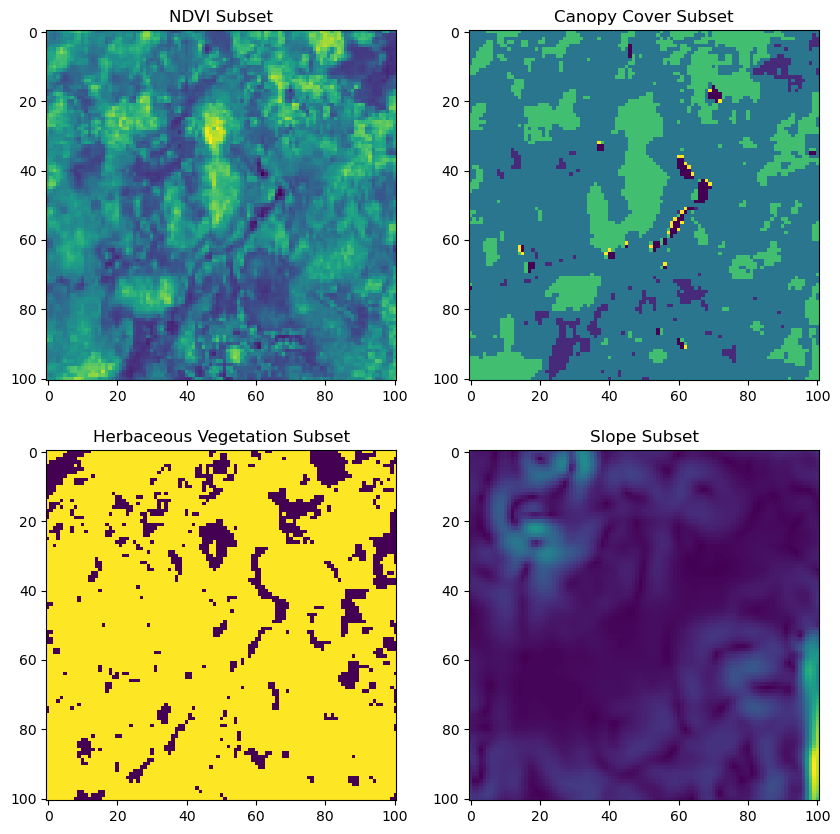

In [23]:
x = 2.5e4
y = -1.44e6
window_size = 101

ndvi_subset, origin_x, origin_y = subset_raster_with_padding_torch(ndvi_global_norm, x, y, window_size, raster_transform)
canopy_subset, origin_x, origin_y = subset_raster_with_padding_torch(canopy_global_norm, x, y, window_size, raster_transform)
herby_subset, origin_x, origin_y = subset_raster_with_padding_torch(herby_global_norm, x, y, window_size, raster_transform)
slope_subset, origin_x, origin_y = subset_raster_with_padding_torch(slope_global_norm, x, y, window_size, raster_transform)

# Plot the subset
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

axs[0, 0].imshow(ndvi_subset.numpy(), cmap='viridis')
axs[0, 0].set_title('NDVI Subset')
# axs[0, 0].axis('off')

axs[0, 1].imshow(canopy_subset.numpy(), cmap='viridis')
axs[0, 1].set_title('Canopy Cover Subset')
# axs[0, 1].axis('off')

axs[1, 0].imshow(herby_subset.numpy(), cmap='viridis')
axs[1, 0].set_title('Herbaceous Vegetation Subset')
# axs[1, 0].axis('off')

axs[1, 1].imshow(slope_subset.numpy(), cmap='viridis')
axs[1, 1].set_title('Slope Subset')
# axs[1, 1].axis('off')



Plot with colour scale

In [24]:
# # Plot the subset
# fig, axs = plt.subplots(2, 2)

# im1 = axs[0, 0].imshow(ndvi_subset.numpy(), cmap='viridis')
# axs[0, 0].set_title('NDVI Subset')
# fig.colorbar(im1, ax=axs[0, 0])
# # axs[0, 0].axis('off')

# im2 = axs[0, 1].imshow(canopy_subset.numpy(), cmap='viridis')
# axs[0, 1].set_title('Canopy Cover Subset')
# fig.colorbar(im2, ax=axs[0, 1])
# # axs[0, 1].axis('off')

# im3 = axs[1, 0].imshow(herby_subset.numpy(), cmap='viridis')
# axs[1, 0].set_title('Herbaceous Vegetation Subset')
# fig.colorbar(im3, ax=axs[1, 0])
# # axs[1, 0].axis('off')

# im4 = axs[1, 1].imshow(slope_subset.numpy(), cmap='viridis')
# axs[1, 1].set_title('Slope Subset')
# fig.colorbar(im4, ax=axs[1, 1])
# # axs[1, 1].axis('off')

# plt.tight_layout()
# plt.show()

## Dealing with NaN values

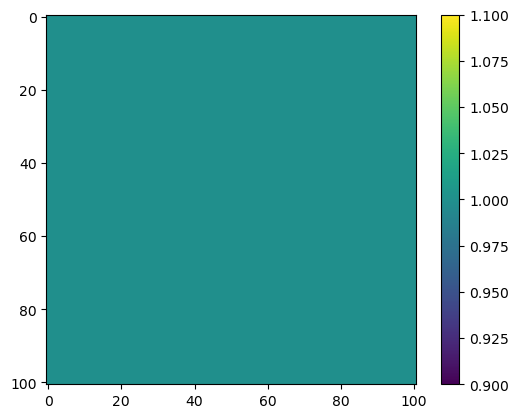

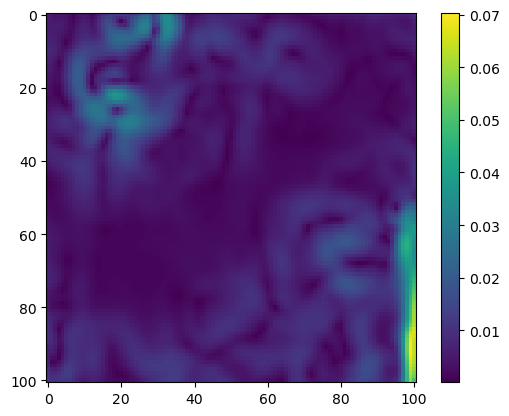

In [25]:
layer = ndvi_subset
# layer = ndvi_global_norm
layer = slope_subset

# are there nans in the array?
# print(torch.isnan(layer).any())

# Create mask where original array has values of -1, which is only at the edges as everything else is normalised between 0 and 1
mask = np.where(layer == -1, -np.inf, 1)
# mask = np.where(np.isnan(layer), 0., 1.)
# print(mask)

plt.imshow(mask)
plt.colorbar()
plt.show()

# # Replace NaNs in the original array with 0
# layer_filled = np.nan_to_num(layer, nan=0.)

layer_updated = layer * mask

plt.imshow(layer_updated)
plt.colorbar()
plt.show()

## Stack the subset layers

In [26]:
# Stack the channels along a new axis; here, 1 is commonly used for channel axis in PyTorch
subset_stack = torch.stack([ndvi_subset, canopy_subset, herby_subset, slope_subset], dim=0)
subset_stack
x1 = subset_stack
x1 = x1.unsqueeze(0)
print(x1.shape)
# print(x1)

torch.Size([1, 4, 101, 101])


### Additional data

In [27]:
def repeat_sequence(sequence, length_out):
    return np.resize(sequence, length_out)

# hour of the day (hour) sequence
hour_t2 = np.resize(range(24), n_steps)
# print(hour_t2)
# convert to sine and cosine
hour_t2_sin = np.sin(2*np.pi*hour_t2/24)
hour_t2_cos = np.cos(2*np.pi*hour_t2/24)

# day of the year (yday) sequence
yday_sequence = np.repeat(range(250, 365), 24)
yday_t2 = np.resize(yday_sequence, n_steps)
# print(yday_t2)
# convert to sine and cosine
yday_t2_sin = np.sin(2*np.pi*yday_t2/365)
yday_t2_cos = np.cos(2*np.pi*yday_t2/365)

# bearing vector
bearing = np.repeat(0, n_steps)
# bearing_sin = np.sin(bearing)
# bearing_cos = np.cos(bearing)
# print(bearing_sin, bearing_cos)

# Convert lists to PyTorch tensors
hour_t2_tensor = torch.tensor(hour_t2).float()
hour_t2_sin_tensor = torch.tensor(hour_t2_sin).float()
hour_t2_cos_tensor = torch.tensor(hour_t2_cos).float()
yday_t2_tensor = torch.tensor(yday_t2).float()
yday_t2_sin_tensor = torch.tensor(yday_t2_sin).float()
yday_t2_cos_tensor = torch.tensor(yday_t2_cos).float()
bearing = torch.tensor(bearing).float()
# bearing_sin = torch.tensor(bearing_sin).float()
# bearing_cos = torch.tensor(bearing_cos).float()

# Stack tensors column-wise to create a tensor of shape [n_steps, 6]
# x2_full = torch.stack((hour_t2_sin_tensor, hour_t2_cos_tensor, yday_t2_sin_tensor, yday_t2_cos_tensor, bearing_sin, bearing_cos), dim=1)
# Stack tensors column-wise to create a tensor of shape [n_steps, 4]
x2_full = torch.stack((hour_t2_sin_tensor, hour_t2_cos_tensor, yday_t2_sin_tensor, yday_t2_cos_tensor), dim=1)
# x3_full = x2_full
# print(x2.shape)  # Should output torch.Size([100, 2])
# print(x2)

# x2 = torch.tensor([hour_t2, yday_t2]).float()
# x2 = x2.unsqueeze(0)
print(x2_full.shape)
# print(x2)
print(x2_full[59,:])
print(bearing[59])

torch.Size([1000, 4])
tensor([ 0.2588, -0.9659, -0.9307, -0.3657])
tensor(0.)


## Run the model on the subsetted layers

tensor([ 0.2588,  0.9659, -0.9176, -0.3975])
tensor([[0.]])
1.0000000278275352
250.00000220706653


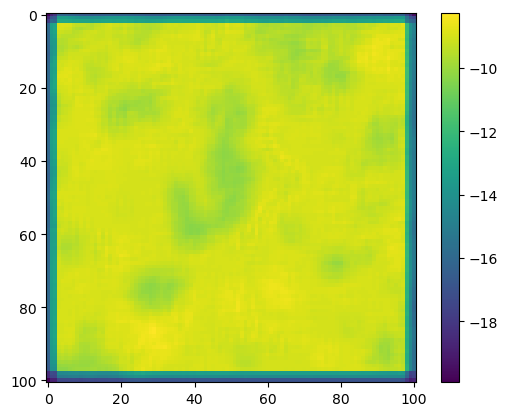

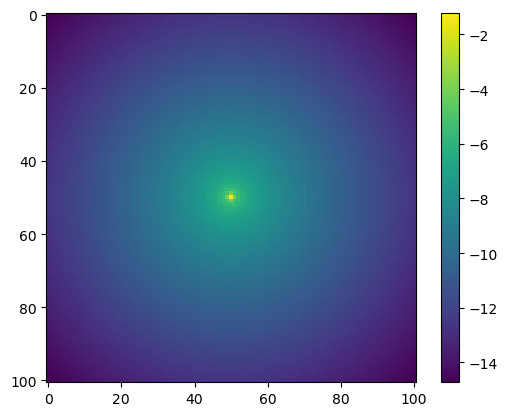

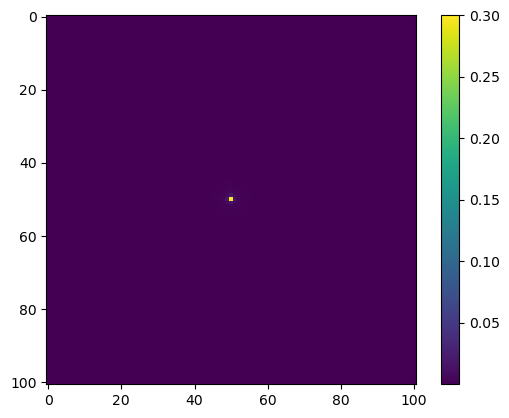

torch.Size([101, 101])


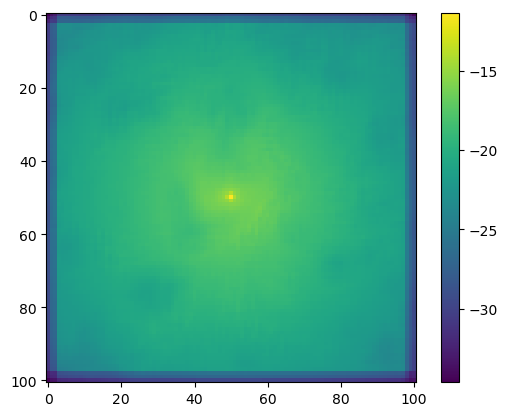

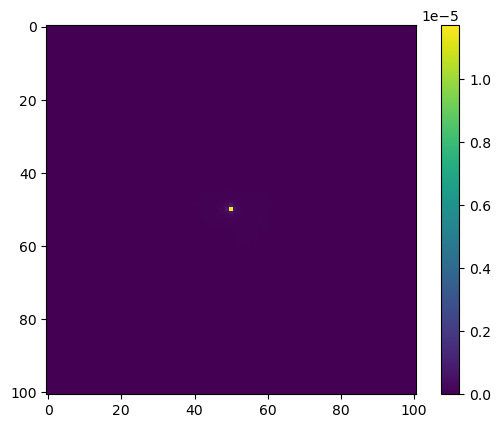

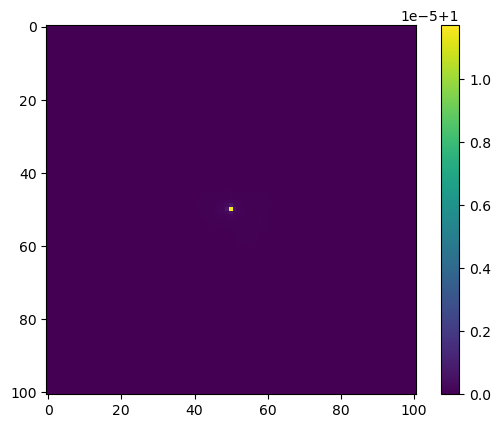

In [28]:
# print(x1.shape)
# print(x2[1,:].unsqueeze(0).shape)

# # print(x1)
# print(x2[1,:].unsqueeze(0).detach().numpy()[0,:])
# # print(x2[53,:], keep)
step = 1
test = model((x1, x2_full[step,:].unsqueeze(0), bearing[step].unsqueeze(0).unsqueeze(0)))
print(x2_full[step,:])
print(bearing[step].unsqueeze(0).unsqueeze(0))

x2_step = x2_full[step,:]

# Pull out the scalars
hour_t2_sin = x2_step.detach().numpy()[0]
hour_t2_cos = x2_step.detach().numpy()[1]
yday_t2_sin = x2_step.detach().numpy()[2]
yday_t2_cos = x2_step.detach().numpy()[3]
# bearing_sin = x2_step.detach().numpy()[4]
# bearing_cos = x2_step.detach().numpy()[5]

def recover_hour(sin_term, cos_term):
    # Calculate the angle theta
    theta = np.arctan2(sin_term, cos_term)
    # Calculate hour_t2
    hour = (12 * theta) / np.pi % 24
    return hour

hour_t2 = recover_hour(hour_t2_sin, hour_t2_cos)
print(hour_t2)

def recover_yday(sin_term, cos_term):
    # Calculate the angle theta
    theta = np.arctan2(sin_term, cos_term)
    # Calculate hour_t2
    yday = (365 * theta) / (2 * np.pi)  % 365
    return yday

yday_t2 = recover_yday(yday_t2_sin, yday_t2_cos)
print(yday_t2)

# plot the results of the habitat density as an image
plt.imshow(test.detach().numpy()[0,:,:,0])
plt.colorbar()
plt.show()

# plot the results of the movement density as an image
plt.imshow(test.detach().numpy()[0,:,:,1])
plt.colorbar()
plt.show()

# plot the results of the exp movement density as an image
plt.imshow(np.exp(test.detach().numpy()[0,:,:,1]))
plt.colorbar()
plt.show()

test_cat = (test[:, :, :, 0] + test[:, :, :, 1])
# test_cat = torch.log(test[:, :, :, 0]*test[:, :, :, 1])
# test_cat = -1 * test[:, :, :, 0] * torch.exp(test[:, :, :, 1])

test_cat = test_cat.squeeze()
print(test_cat.shape)

# # Create mask where original array has values of -1, which is only at the edges as everything else is normalised between 0 and 1
layer = ndvi_subset
mask = torch.where(layer == -1, torch.tensor(float('nan')), 1)
# mask = torch.where(layer == -1, 0, 1)
# mask = np.where(np.isnan(layer), 0., 1.)

# plt.imshow(mask)
# plt.colorbar()
# plt.show()

test_cat = test_cat * mask

plt.imshow(test_cat.detach().numpy()[:,:])
plt.colorbar()
plt.show()

plt.imshow(np.exp(test_cat.detach().numpy()[:,:]))
plt.colorbar()
plt.show()

test_cat_exp = torch.exp(test_cat)
# replace NaNs with 0
test_cat_exp = torch.nan_to_num(test_cat_exp, nan=0.)
plt.imshow(np.exp(test_cat_exp.detach().numpy()[:,:]))
plt.colorbar()
plt.show()


## Sample from the probability surface

In [29]:
# sample from the array values
test_cat_exp = torch.exp(test_cat)
# replace NaNs with 0
test_cat_exp = torch.nan_to_num(test_cat_exp, nan=0.)
# normalise the array
test_cat_exp = test_cat_exp/torch.sum(test_cat_exp)
# print(test_cat_exp)
print(torch.sum(test_cat_exp))

# Flatten the probability surface
flat_prob_surface = test_cat_exp.flatten().detach().numpy()
print(flat_prob_surface)

# Generate the corresponding indices for the flattened array
indices = np.arange(flat_prob_surface.size)

# Sample from the flattened probability surface
sampled_index = np.random.choice(indices, p=flat_prob_surface)

# Convert the sampled index back to 2D coordinates
sampled_coordinates = np.unravel_index(sampled_index, test_cat_exp.shape)

print("Sampled coordinates:", sampled_coordinates)

tensor(1.0000, dtype=torch.float64, grad_fn=<SumBackward0>)
[1.59497207e-11 5.30195943e-11 9.75965645e-11 ... 1.04326211e-10
 4.12675436e-11 4.64865832e-11]
Sampled coordinates: (42, 67)


## Return sampled point to geographic coordinates

In [30]:
# original locations
print(x ,y)
print(sampled_coordinates)
print(px, py)

# row_start = py - half_window
# row_stop = py + half_window + 1
# col_start = px - half_window
# col_stop = px + half_window + 1

print(row_start, col_start)
new_px = origin_x + sampled_coordinates[0]
new_py = origin_y + sampled_coordinates[1]
print(new_px)
print(new_py)

# Convert geographic coordinates to pixel coordinates
new_x, new_y = raster_transform * (new_px, new_py)
print(new_x, new_y)

25000.0 -1440000.0
(42, 67)
1480 1160
1590 2310
992
1377
24800.0 -1440425.0


# Full trajectory function

In [31]:
def simulate_trajectory(global_raster_tensors, 
                        scalars_to_grid,
                        # additional_data_tensor,
                        bearing,
                        window_size, 
                        x_loc, 
                        y_loc,
                        global_raster_transform):
    # Convert geographic coordinates to pixel coordinates
    x = x_loc
    y = y_loc

    # ndvi_subset, origin_x, origin_y = subset_raster_with_padding_torch(ndvi_global_norm, x, y, window_size, global_raster_transform)
    # canopy_subset, origin_x, origin_y = subset_raster_with_padding_torch(canopy_global_norm, x, y, window_size, global_raster_transform)
    # herby_subset, origin_x, origin_y = subset_raster_with_padding_torch(herby_global_norm, x, y, window_size, global_raster_transform)
    # slope_subset, origin_x, origin_y = subset_raster_with_padding_torch(slope_global_norm, x, y, window_size, global_raster_transform)

    # Apply the processing function to each tensor in the list
    # subset_rasters_tensors, origin_x, origin_y = [subset_raster_with_padding_torch(raster_tensor, x=start_x, y=start_y, window_size=101, transform=raster_transform) for raster_tensor in global_raster_tensors]
    # print(subset_rasters_tensors.shape)
    
    results = [subset_raster_with_padding_torch(raster_tensor, x=x_loc, y=y_loc, window_size=window_size, transform=global_raster_transform) for raster_tensor in global_raster_tensors]
    
    # Unpacking the results
    subset_rasters_tensors, origin_xs, origin_ys = zip(*results)
    # print(subset_rasters_tensors)
    
    
    
    # Stack the processed tensors along a new dimension (e.g., dimension 0)
    x1 = torch.stack(subset_rasters_tensors, dim=0)
    x1 = x1.unsqueeze(0)
    # print(x1.shape)

    single_layer = x1[0, 0, :, :]
    # plt.imshow(single_layer.detach().numpy()[:,:])
    # plt.colorbar()
    # plt.show()

    # create masking layer to remove outside of the extent
    mask = torch.where(single_layer == -1, torch.tensor(float('nan')), 1)
    
    # test_cat_exp = torch.exp(test_cat)

    # extract NaNs to pad and make masking layer
    x2 = scalars_to_grid
    # x3 = additional_data_tensor

    x3 = bearing

    test = model((x1, x2, x3))
    # print(test.shape)

    hab_log_prob = test[:, :, :, 0]
    move_log_prob = test[:, :, :, 1]

    step_log_prob = (hab_log_prob + move_log_prob)
    # test_cat = torch.log(test[:, :, :, 0]*test[:, :, :, 1])
    # test_cat = -1 * test[:, :, :, 0] * torch.exp(test[:, :, :, 1])
    # apply the mask (set NaN probs to -inf)
    step_log_prob = step_log_prob * mask

    hab_log_prob = hab_log_prob.squeeze()
    move_log_prob = move_log_prob.squeeze()
    step_log_prob = step_log_prob.squeeze()

    # print(test_cat.shape)

    # # normalise the raster for plotting
    # test_cat_norm = test_cat/-torch.sum(test_cat)

    # plt.imshow(test_cat_norm.detach().numpy()[:,:])
    # plt.colorbar()
    # plt.draw()  # Ensure the plot is rendered
    # plt.savefig(f"outputs/dl_prob_maps/log_prob_surface_{i}.png", dpi=300)
    # plt.show()
    # plt.close()  # Close the figure to free memory

    # sample from the array values
    step_prob = torch.exp(step_log_prob)
    step_prob = torch.nan_to_num(step_prob, nan=0.)
    step_prob_norm = step_prob/torch.sum(step_prob)
    # print(test_cat_exp)
    # print(torch.sum(test_cat_exp))

    # plt.imshow(test_cat_exp.detach().numpy()[:,:])
    # plt.colorbar()
    # plt.show()

    # Flatten the probability surface
    flat_step_prob_norm = step_prob_norm.flatten().detach().numpy()
    # print(flat_prob_surface)

    # Generate the corresponding indices for the flattened array
    indices = np.arange(flat_step_prob_norm.size)

    # Sample from the flattened probability surface
    sampled_index = np.random.choice(indices, p=flat_step_prob_norm)

    # Convert the sampled index back to 2D coordinates
    sampled_coordinates = np.unravel_index(sampled_index, step_prob_norm.shape)

    # print("Sampled coordinates:", sampled_coordinates)

    # recover the geographic coordinates of the sampled location
    new_px = origin_xs[0] + sampled_coordinates[0]
    new_py = origin_ys[0] + sampled_coordinates[1]
    # print(new_px, new_py)

    # Convert geographic coordinates to pixel coordinates
    new_x, new_y = raster_transform * (new_px, new_py)

    # Place the sampled location at a random point within the cell (rather than the centre)
    new_x = new_x + np.random.uniform(-12.5, 12.5)
    new_y = new_y + np.random.uniform(-12.5, 12.5)

    # print(new_x, new_y)

    # return new_x, new_y, step_prob
    return new_x, new_y, hab_log_prob, move_log_prob, step_log_prob


## Call the function

In [32]:
global_raster_list = [ndvi_global_norm, canopy_global_norm, herby_global_norm, slope_global_norm]
x2 = x2_full[3,:].unsqueeze(0)
# x3 = x2
bearing_step = bearing[3].unsqueeze(0).unsqueeze(0)
print(x2)
print(bearing.shape)

simulate_trajectory(global_raster_tensors=global_raster_list,
                    scalars_to_grid=x2,
                    # additional_data_tensor=x3,
                    bearing=bearing_step,
                    window_size=101,
                    x_loc=5.9e4,
                    y_loc=-1.4325e6,
                    global_raster_transform=raster_transform)

tensor([[ 0.7071,  0.7071, -0.9176, -0.3975]])
torch.Size([1000])


(58626.54325657767,
 -1432850.0210754569,
 tensor([[-20.6350, -19.6841, -19.1968,  ..., -14.7901, -19.5534, -17.8747],
         [-19.8522, -18.2344, -18.0573,  ..., -11.2221, -18.2112, -14.3592],
         [-18.8011, -17.3047, -17.4446,  ...,  -9.8291, -17.3457, -11.7522],
         ...,
         [-19.2759, -17.9602, -17.5080,  ...,  -9.3690, -17.1221, -11.2912],
         [-19.3518, -18.0277, -17.6444,  ..., -12.0853, -17.0381, -12.5764],
         [-20.3847, -19.2195, -18.8313,  ..., -15.0510, -17.2327, -14.6177]],
        dtype=torch.float64, grad_fn=<SqueezeBackward0>),
 tensor([[-14.3037, -14.2413, -14.1796,  ..., -14.1800, -14.2418, -14.3041],
         [-14.2413, -14.1783, -14.1158,  ..., -14.1162, -14.1787, -14.2417],
         [-14.1795, -14.1157, -14.0525,  ..., -14.0529, -14.1162, -14.1799],
         ...,
         [-14.1795, -14.1157, -14.0525,  ..., -14.0529, -14.1162, -14.1799],
         [-14.2413, -14.1783, -14.1158,  ..., -14.1162, -14.1787, -14.2417],
         [-14.3037, -14.

# Generate trajectory

## Setup parameters

In [33]:
# Setup the simulation parameters
n_steps = 50
starting_yday = 1

# start_x = 1.0e4
# start_y = -1.42e6

# starting location of buffalo 2005
# start_x = 41969.310875
# start_y = -1.435671e+06

# starting location of buffalo 2158
start_x = 26818.16	
start_y = -1432572	

global_raster_list = [ndvi_global_norm, canopy_global_norm, herby_global_norm, slope_global_norm]
window_size = 101
global_raster_transform = raster_transform


## Create simulation inputs from the parameters

In [34]:
x = np.repeat(0., n_steps)
y = np.repeat(0., n_steps)
# bearing = np.repeat(0., n_steps)
# print(x)

x[0], y[0] = start_x, start_y
# bearing[0] = np.random.uniform(0, 360)
# print(x, y)

# Create sequence of steps
step = range(1, n_steps)
# print(step)

# hour of the day (hour) sequence
hour_t2 = np.resize(range(24), n_steps)
# print(hour_t2)
# convert to sine and cosine
hour_t2_sin = np.sin(2*np.pi*hour_t2/24)
hour_t2_cos = np.cos(2*np.pi*hour_t2/24)

# day of the year (yday) sequence
yday_sequence = np.repeat(range(1, 365), 24)
yday_t2 = yday_sequence[yday_sequence > starting_yday - 1]
yday_t2 = np.resize(yday_t2, n_steps)
# print(yday_t2)
# convert to sine and cosine
yday_t2_sin = np.sin(2*np.pi*yday_t2/365)
yday_t2_cos = np.cos(2*np.pi*yday_t2/365)

# bearing vector
bearing = np.repeat(0., n_steps)
# bearing_sin = np.sin(2*np.pi*bearing/360)
# bearing_cos = np.cos(2*np.pi*bearing/360)
# print(bearing_sin, bearing_cos)

# Convert lists to PyTorch tensors
hour_t2_tensor = torch.tensor(hour_t2).float()
hour_t2_sin_tensor = torch.tensor(hour_t2_sin).float()
hour_t2_cos_tensor = torch.tensor(hour_t2_cos).float()
yday_t2_tensor = torch.tensor(yday_t2).float()
yday_t2_sin_tensor = torch.tensor(yday_t2_sin).float()
yday_t2_cos_tensor = torch.tensor(yday_t2_cos).float()  
bearing_tensor = torch.tensor(bearing).float()
# bearing_sin = torch.tensor(bearing_sin).float()
# bearing_cos = torch.tensor(bearing_cos).float()

# Stack tensors column-wise to create a tensor of shape [n_steps, 6]
# x2_full = torch.stack((hour_t2_sin_tensor, hour_t2_cos_tensor, yday_t2_sin_tensor, yday_t2_cos_tensor, bearing_sin, bearing_cos), dim=1)
# Stack tensors column-wise to create a tensor of shape [n_steps, 4]
x2_full = torch.stack((hour_t2_sin_tensor, hour_t2_cos_tensor, yday_t2_sin_tensor, yday_t2_cos_tensor), dim=1)
# x3_full = x2_full
# print(head(x2_full))

# List to hold filenames of saved images
filenames_hab = []
filenames_move = []
filenames_step = []

## Trajectory loop

In [35]:
for i in range(1, n_steps):

    x_loc = x[i-1]
    y_loc = y[i-1]

    # calculate the bearing from the previous location
    if i > 1:
        bearing_rad = np.arctan2(y[i-1] - y[i-2], x[i-1] - x[i-2])
        # bearing_rad = np.random.uniform(-np.pi, np.pi)
    else:
        bearing_rad = np.random.uniform(-np.pi, np.pi)

    # Convert bearing to sine and cosine
    # bearing_sin = np.sin(2*np.pi*bearing_rad)
    # bearing_cos = np.cos(2*np.pi*bearing_rad)
    # print(bearing_sin, bearing_cos)

    # Convert bearing from radians to degrees for storing in the vector
    bearing[i-1] = bearing_rad
    # print("Bearing[i-1]", bearing[i-1])

    # bearing_rad.unsqueeze(0).unsqueeze(0)

    # Update the x2 tensor with the new bearing
    # x2_full[i, 4] = torch.tensor(bearing_sin).float()
    # x2_full[i, 5] = torch.tensor(bearing_cos).float()

    bearing_tensor = torch.tensor(bearing[i-1]).unsqueeze(0).unsqueeze(0)

    x2 = x2_full[i,:].unsqueeze(dim=0)
    # print(x2)
    
    sim_outputs = simulate_trajectory(global_raster_tensors=global_raster_list,
                                      scalars_to_grid=x2,
                                    #   additional_data_tensor=x2,
                                      bearing=bearing_tensor,
                                      window_size=101,
                                      x_loc=x_loc,
                                      y_loc=y_loc,
                                      global_raster_transform=global_raster_transform)
    
    new_x, new_y, hab_log_prob, move_log_prob, step_log_prob = sim_outputs
    
    # print(new_x, new_y)

    x[i] = new_x
    y[i] = new_y


    # ### PLOTTING

    ## Habitat probability surface
    # normalise the raster for plotting
    hab_log_prob_norm = hab_log_prob/-torch.sum(hab_log_prob)
    # convert to numpy array
    hab_log_prob_norm = hab_log_prob_norm.detach().numpy()[:,:]
    # Save the figure
    filename_hab = f"outputs/dl_prob_maps/id2158_TAmix_hab_log_prob_norm_{i}.png"
    plt.figure()  # Create a new figure
    plt.imshow(hab_log_prob_norm)
    plt.colorbar()
    plt.draw()  # Ensure the plot is rendered
    plt.savefig(filename_hab, dpi=300)
    # plt.show()
    plt.close()  # Close the figure to free memory
    # Add filename to the list
    filenames_hab.append(filename_hab)  

    ### Movement probability surface
    # normalise the raster for plotting
    move_log_prob_norm = move_log_prob/-torch.sum(move_log_prob)
    # convert to numpy array
    move_log_prob_norm = move_log_prob_norm.detach().numpy()[:,:]
    # Save the figure
    filename_move = f"outputs/dl_prob_maps/id2158_TAmix_move_log_prob_norm_{i}.png"
    plt.figure()  # Create a new figure
    plt.imshow(move_log_prob_norm)
    plt.colorbar()
    plt.draw()  # Ensure the plot is rendered
    plt.savefig(filename_move, dpi=300)
    # plt.show()
    plt.close()  # Close the figure to free memory
    # Add filename to the list
    filenames_move.append(filename_move)  


    ### Step selection probability surface
    # normalise the raster for plotting
    log_prob_surface_norm = step_log_prob/-torch.sum(step_log_prob)
    # convert to numpy array
    log_prob_surface_norm = log_prob_surface_norm.detach().numpy()[:,:]
    # Save the figure
    filename = f"outputs/dl_prob_maps/id2158_TAmix_log_prob_surface_{i}.png"
    plt.figure()  # Create a new figure
    plt.imshow(log_prob_surface_norm)
    plt.colorbar()
    plt.draw()  # Ensure the plot is rendered
    plt.savefig(filename, dpi=300)
    # plt.show()
    plt.close()  # Close the figure to free memory
    # Add filename to the list
    filenames_step.append(filename)  


### Checking the model outputs

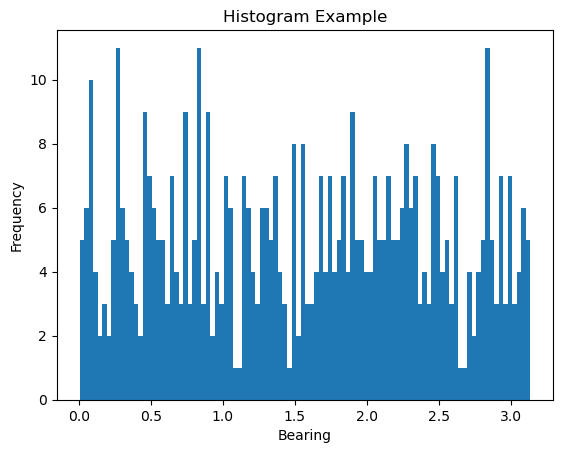

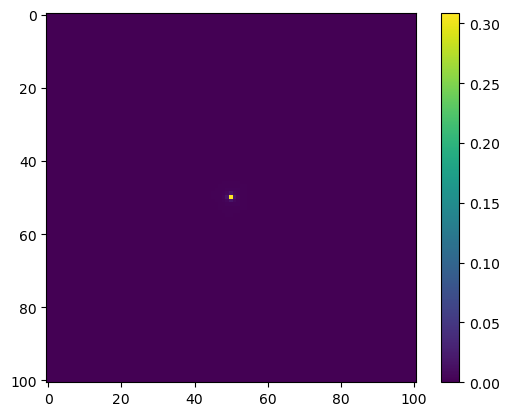

In [42]:
# print(bearing)
plt.hist(bearing[bearing>0], bins=100) #, edgecolor='black'
plt.title('Histogram Example')
plt.xlabel('Bearing')
plt.ylabel('Frequency')
plt.show()

step_log_prob_norm = step_log_prob/torch.sum(step_log_prob)
# print(step_log_prob_norm)

# check for NaN values
# print(torch.isnan(step_log_prob_norm).any())

step_prob = torch.exp(step_log_prob)

step_prob_norm = step_prob/torch.sum(step_prob)
# print(torch.sum(step_prob_norm))

plt.imshow(step_prob_norm.detach().numpy()[:,:])
plt.colorbar()
plt.show()

# # Create a histogram
# plt.hist(step_prob_norm.detach().numpy()[:,:], bins=100) #, edgecolor='black'
# # Add title and labels
# plt.title('Histogram Example')
# plt.xlabel('Value')
# plt.ylabel('Frequency')

# Show the plot
plt.show()

# ndvi_global_norm = (ndvi_global_tens - ndvi_min) / (ndvi_max - ndvi_min)

## Plot the simulated trajectory

50
50


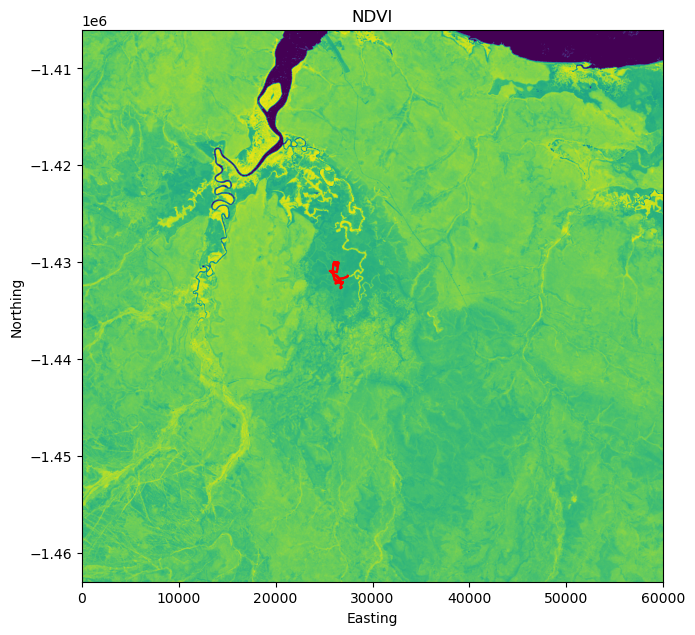

In [37]:
# Actual number of locations before there were NaNs
# print(x)
print(x[x>0].shape[0])

# Create a figure and axis with matplotlib
fig, ax = plt.subplots(figsize=(7.5, 7.5))
# Plot the raster
show(ndvi_global, transform=raster_transform, ax=ax, cmap='viridis')

# Set the title and labels
ax.set_title('NDVI')
ax.set_xlabel('Easting')
ax.set_ylabel('Northing')

# Plot the simulated trajectory
no_sim_points = np.min([x[x>0].shape[0], y[y<0].shape[0]])
print(no_sim_points)
plt.plot(x[1:no_sim_points], y[1:no_sim_points], color = 'red')
plt.plot(x[1:no_sim_points], y[1:no_sim_points], color = 'red')
# Show the plot
plt.show()


## Write the trajectory to a csv

### Only run this once otherwise it will create duplicates

In [38]:
# Combine vectors into a DataFrame
trajectory_df = pd.DataFrame({'x': x[x>0], 'y': y[x>0], 'hour': hour_t2[x>0], 'yday': yday_t2[x>0]})
n_steps_actual = x[x>0].shape[0]

# Save the DataFrame to a CSV file
index = 1
csv_filename = f'outputs/dl_trajectories/dl_trajectory_{n_steps_actual}steps_{index}.csv'

# Check if the file already exists and find a new name if necessary
while os.path.exists(csv_filename):
    csv_filename = f'outputs/dl_trajectories/dl_trajectory_{n_steps_actual}steps_{index}.csv'
    index += 1

print(csv_filename)
trajectory_df.to_csv(csv_filename, index=True)

outputs/dl_trajectories/dl_trajectory_50steps_1.csv


## Create gif from images

In [39]:
# # Create a GIF from the saved images
# with imageio.get_writer('outputs/gifs/log_prob_surface.gif', mode='I', loop=0, fps = 5) as writer:
#     for filename in filenames:
#         image = imageio.imread(filename)
#         writer.append_data(image)

## Multiple trajectories in a loop

In [40]:
# Setup the simulation parameters
n_trajectories = 10
n_steps = 1000
starting_yday = 1

# starting location
# start_x = 1.0e4
# start_y = -1.42e6

# starting location of buffalo 2005
# start_x = 41941.33 
# start_y = -1435875

global_raster_list = [ndvi_global_norm, canopy_global_norm, herby_global_norm, slope_global_norm]
window_size = 101
global_raster_transform = raster_transform


# Looping over individuals

for j in range(1, n_trajectories+1):

    # Setup the vectors used in the prediction function
    x = np.repeat(0., n_steps)
    y = np.repeat(0., n_steps)
    x[0], y[0] = start_x, start_y

    # Create sequence of steps
    step = range(1, n_steps)

    # hour of the day (hour) sequence
    hour_t2 = np.resize(range(24), n_steps)
    # convert to sine and cosine
    hour_t2_sin = np.sin(2*np.pi*hour_t2/24)
    hour_t2_cos = np.cos(2*np.pi*hour_t2/24)

    # day of the year (yday) sequence
    yday_sequence = np.repeat(range(1, 365), 24)
    yday_t2 = yday_sequence[yday_sequence > starting_yday - 1]
    yday_t2 = np.resize(yday_t2, n_steps)
    # convert to sine and cosine
    yday_t2_sin = np.sin(2*np.pi*yday_t2/365)
    yday_t2_cos = np.cos(2*np.pi*yday_t2/365)

    # bearing vector
    bearing = np.repeat(0., n_steps)

    # Convert lists to PyTorch tensors
    hour_t2_tensor = torch.tensor(hour_t2).float()
    hour_t2_sin_tensor = torch.tensor(hour_t2_sin).float()
    hour_t2_cos_tensor = torch.tensor(hour_t2_cos).float()
    yday_t2_tensor = torch.tensor(yday_t2).float()
    yday_t2_sin_tensor = torch.tensor(yday_t2_sin).float()
    yday_t2_cos_tensor = torch.tensor(yday_t2_cos).float()  
    bearing_tensor = torch.tensor(bearing).float()

    # Stack tensors column-wise to create a tensor of shape [n_steps, 4]
    x2_full = torch.stack((hour_t2_sin_tensor, hour_t2_cos_tensor, yday_t2_sin_tensor, yday_t2_cos_tensor), dim=1)


    # simulation loop
    
    for i in range(1, n_steps):

        x_loc = x[i-1]
        y_loc = y[i-1]

        # calculate the bearing from the previous location
        if i > 1:
            bearing_rad = np.arctan2(y[i-1] - y[i-2], x[i-1] - x[i-2])
        else:
            bearing_rad = np.random.uniform(-np.pi, np.pi)

        # store bearing in the vector
        bearing[i-1] = bearing_rad
        bearing_tensor = torch.tensor(bearing[i-1]).unsqueeze(0).unsqueeze(0)

        x2 = x2_full[i,:].unsqueeze(dim=0)
        
        sim_outputs = simulate_trajectory(global_raster_tensors=global_raster_list,
                                        scalars_to_grid=x2,
                                        bearing=bearing_tensor,
                                        window_size=101,
                                        x_loc=x_loc,
                                        y_loc=y_loc,
                                        global_raster_transform=global_raster_transform)
        
        new_x, new_y, hab_log_prob, move_log_prob, step_log_prob = sim_outputs

        x[i] = new_x
        y[i] = new_y


    # save the data frames individually
    # Combine vectors into a DataFrame
    trajectory_df = pd.DataFrame({'x': x[x>0], 'y': y[x>0], 'hour': hour_t2[x>0], 'yday': yday_t2[x>0]})
    n_steps_actual = x[x>0].shape[0]

    # Save the DataFrame to a CSV file
    index = j
    csv_filename = f'outputs/dl_trajectories/dl_trajectory_{n_steps_actual}steps_{index}.csv'

    # # Check if the file already exists and find a new name if necessary
    # while os.path.exists(csv_filename):
    #     csv_filename = f'outputs/dl_trajectories/dl_trajectory_{n_steps_actual}steps_{index}.csv'
    #     # index += 1

    print(csv_filename)
    trajectory_df.to_csv(csv_filename, index=True)


outputs/dl_trajectories/dl_trajectory_1000steps_1.csv
outputs/dl_trajectories/dl_trajectory_1000steps_2.csv
outputs/dl_trajectories/dl_trajectory_1000steps_3.csv
outputs/dl_trajectories/dl_trajectory_1000steps_4.csv
outputs/dl_trajectories/dl_trajectory_1000steps_5.csv
outputs/dl_trajectories/dl_trajectory_1000steps_6.csv
outputs/dl_trajectories/dl_trajectory_1000steps_7.csv
outputs/dl_trajectories/dl_trajectory_1000steps_8.csv
outputs/dl_trajectories/dl_trajectory_1000steps_9.csv
outputs/dl_trajectories/dl_trajectory_1000steps_10.csv
